### Generating Embeddings

Paper: https://pubs.rsna.org/doi/suppl/10.1148/ryai.210174 

Code: https://github.com/tarakapoor/thyroid_deep_learning

Dataset: https://stanfordaimi.azurewebsites.net/datasets/a72f2b02-7b53-4c5d-963c-d7253220bfd5


In [1]:
#req
import pandas as pd
from PIL import Image
import os
import os.path

import numpy as np
import re
from pathlib import Path
import tables
import cv2
import h5py
import math
import random

#data aug
from albumentations.pytorch import ToTensorV2
#from albumentations.pytorch import ToTensor
import albumentations as A

import torch.optim as optim
import torch.utils.data as data
import torch
from torch.utils.data import DataLoader
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, f1_score


import h5py
import cv2
from PIL import Image



In [2]:
#stl
import os
import warnings

#data handling
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm

#stats
import scipy
import sklearn

#network
import networkx as nx

#vis
import matplotlib.pyplot as plt
import seaborn as sns

#torch

sns.set(font_scale = 1.5)
sns.set_theme()

##### Reading in the Data [REVISED FUNCTIONS from mobilenet_preprocess.py]

In [3]:
## HELPER FUNCTIONS!! (in mobilenet_preprocess.py)
#needed for singleframe (largest), can use for all frame types
def transform_and_crop_largest(imgs, masks, pats):
    """Crop images and resize them to 224x224.
    Create list with a 1 at the frame index of the largest sized nodule in each patient.
    Return list of all cropped and resized images, and the list of largest patient indices."""
    all_imgs_cropped=[]
    newpats = []
    biggestinpat = np.zeros((len(imgs)))
    firstinpat = False
    patmaxarea = 0
    patmaxareaind = 0
    
    #pats.pop(0) #take out title row
    
    #cropping approach by mask (crop before resizing):
    for im in range(len(imgs)):
        if(pats[im] not in newpats):
            newpats.append(pats[im])
            firstinpat = True
            if(len(newpats) > 1):
                biggestinpat[patmaxareaind] = 1
                #print("last patient", pats[im-1], "(check)", pats[patmaxareaind], "max area", patmaxarea, "at ind", patmaxareaind)
            
            patmaxarea = 0
            patmaxareaind = 0
        else:
            firstinpat = False
        
        cv_im = imgs[im]
        mask = masks[im]
        cropped_im = crop_bounding_box(cv_im, mask) #needs 3 channels
        
        #downsize images with PIL 
        cropped_im = np.asarray(cropped_im)
        new_im = Image.fromarray(cropped_im) #convert to PIL format Image
        
        #lesion area
        w, h = new_im.size
        if(w*h >= patmaxarea): #if largest, update patientmaxarea variables
            patmaxareaind = im
            patmaxarea = w*h
            #print("in patient", pats[im], "biggest area so far", patmaxarea,"index", im)
        
        new_im = new_im.resize((224, 224)) #resize with PIL
        
        if(im == 0):
            print("after resize")
            imgplot = plt.imshow(new_im)
            plt.show() #show cropped and resized image
        
        if(im%1000 == 0):
            print(im)
        
        all_imgs_cropped.append(np.array(new_im))
        
    #do last patient
    biggestinpat[patmaxareaind] = 1
    print(len(newpats), "total pats:", newpats)
    
    print("all images array shape after cropping/resizing:", np.shape(all_imgs_cropped))
    return all_imgs_cropped, biggestinpat
        
    #do last patient
    biggestinpat[patmaxareaind] = 1
    print(len(newpats), "total pats:", newpats)
    
    print("all images array shape after cropping/resizing:", np.shape(all_imgs_cropped))
    return all_imgs_cropped, biggestinpat

#crop around bounding box of mask
#https://www.kaggle.com/whizzkid/crop-images-using-bounding-box
def crop_bounding_box(img, mask):
    """Crop bounding box 5 pixels around nodule mask.
    Used by transform_and_crop functions.
    Return cropped image."""
    info = np.iinfo(mask.dtype)

    ret,thresh = cv2.threshold(mask, 127, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, 1, 2)
    #cnt = contours[0]

    #find coordinates to crop around mask
    (y, x) = np.where(thresh == 255)
    (topy, topx) = (np.min(y), np.min(x))
    (bottomy, bottomx) = (np.max(y), np.max(x))

    out = img[topy-5:bottomy+5, topx-5:bottomx+5] #5 pixel border
    return out

In [4]:
#test the functions
DATA_ROOT = "data/"
metadata_file = DATA_ROOT + "metadata.csv"

file = h5py.File(DATA_ROOT + "dataset.hdf5")
label_df = pd.read_csv(DATA_ROOT + "label_df.csv")

#result1, result2 = transform_and_crop_largest(file["image"], file["mask"], pd.read_csv(DATA_ROOT + "label_df.csv").Annot_IDs.tolist())

functions work properly

##### Creating a Thyroid Dataset Object [REVISED FROM mobilnet_dataset.py]


adjacent 3 stack images

In [5]:
transformNorm = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

In [6]:
def load_datasets_new(project_home_dir, labelpath, phase, cv_phase, allimgs, frametype = "adjacent"):
    """Load images and labels for given phase and cvphase, stack 3 different frames based on frametype (adjacent, equally spaced).
    Keyword arguments:
    phase -- train, val, trainval or test (which data to use)
    cv_phase -- cross validation fold (0 to 4)
    frametype -- adjacent, equalspaced (how to stack frames)
    Return (for given cross validation fold and train/val/trainval/test phase) lists of all images (stacked), labels, patient IDs and frame numbers within patient."""

    print("passed in list allimgs:", np.shape(allimgs))
    
    #colnames = ['Labels for each frame', 'Annot_IDs', 'size_A', 'size_B', 'size_C', 'location_r_l_', 'study_dttm', 'age', 'sex', 'final_diagnoses', 'ePAD ID', 'foldNum']
    label_data = pd.read_csv(labelpath)
    
    annot_ids = label_data.Annot_IDs.tolist() #list of annotation ids from csv file
    labels = label_data.final_diagnoses.tolist() #list of labels from csv file
    
    foldNums = label_data.foldNum.tolist() #list of what folder for train test split
    
    # annot_ids.pop(0)
    # labels.pop(0)
    # foldNums.pop(0)
    
    correct_order_labels = []
    
    for i in range(len(allimgs)):
        correct_order_labels.append(labels[i])
    
    print('Num Images: {}\n Labels: {}\n'.format(len(allimgs), len(correct_order_labels), len(annot_ids)))
    cur_imgs = []
    cur_labels = []
    cur_annot_ids = []

    test_folder = cv_phase #0, 1, 2, 3, 4
    if(cv_phase < 4):
        val_folder = cv_phase+1
    elif(cv_phase == 4):
        val_folder = 0
    
    print("CROSS VALIDATION PHASE:", test_folder)
    #split by foldnum group
    for g in range(len(allimgs)):
        fnum = int(foldNums[g])
        
        if (phase == "train"):
            if not (fnum == test_folder):
                cur_imgs.append(allimgs[g])
                cur_labels.append(correct_order_labels[g])
                cur_annot_ids.append(annot_ids[g])
        elif (phase == "val"):
            if (fnum == test_folder):
                cur_imgs.append(allimgs[g])
                cur_labels.append(correct_order_labels[g])
                cur_annot_ids.append(annot_ids[g])
        elif (phase == "trainval"):
            if not (fnum == test_folder): #train and val images
                cur_imgs.append(allimgs[g])
                cur_labels.append(correct_order_labels[g])
                cur_annot_ids.append(annot_ids[g])
        #else: #test phase
        elif (phase == "all"):
            cur_imgs.append(allimgs[g])
            cur_labels.append(correct_order_labels[g])
            cur_annot_ids.append(annot_ids[g])
    
    
    #label frame number of each image
    cur_frame_num = []
    distinct_patient_ids = []
    patientframenum = 0

    #if 3 images in a row from same patient, stack them (instead of rgb channels)
    for ind in range(len(cur_imgs)):
        if(not (cur_annot_ids[ind] in distinct_patient_ids)):
            distinct_patient_ids.append(cur_annot_ids[ind])
            patientframenum = 1
        cur_frame_num.append(patientframenum) #add index of first image in current frame stack within patient to list for order
        patientframenum += 1
    print(len(cur_imgs), len(cur_labels), len(cur_annot_ids), len(cur_frame_num))

    
    #stack:
    cur_imgs_stack = []
    cur_labels_stack = []
    cur_annot_ids_stack = []
    cur_frame_num_stack = []
    
    distinct_patient_ids = []
    dist = 10
    t = 0
    
    print("about to stack!")
    
    if(frametype == "adjacent"):
        #ADJACENT frame stacking method
        #if 3 images in a row (adjacent) from same patient, stack them (instead of rgb channels)
        while (t < len(cur_imgs)-2):
            if(cur_annot_ids[t] not in distinct_patient_ids):
                distinct_patient_ids.append(cur_annot_ids[t])
            if(cur_annot_ids[t] == cur_annot_ids[t+1] and cur_annot_ids[t] == cur_annot_ids[t+2]):
                img = np.stack((cur_imgs[t], cur_imgs[t+1], cur_imgs[t+2]))
                cur_imgs_stack.append(img)
                cur_labels_stack.append(cur_labels[t])
                cur_annot_ids_stack.append(cur_annot_ids[t])
                cur_frame_num_stack.append(cur_frame_num[t]) #add index of first image in current frame stack within patient to list for order
                if(cur_labels[t] != cur_labels[t+1] or cur_labels[t] != cur_labels[t+2]):
                    print("inconsistent labels in train group of 3 images!")
            t += 3 #every option needs t + 1 to go to next frame   
   
    else:
        #EQUAL SPACED frame stacking method
        while (t < len(cur_imgs) - (2*dist)):
            if(cur_annot_ids[t] not in distinct_patient_ids):
                annot_id = cur_annot_ids[t]
                #last index of this patient id in the list of ids
                last_id = len(cur_annot_ids) - cur_annot_ids[::-1].index(annot_id) - 1
                #print("num in this patient", last_id - t)
                dist = (last_id - t) // 3
                distinct_patient_ids.append(cur_annot_ids[t])
                print("PATIENT", cur_annot_ids[t], "num frames:", last_id-t)

            #if 3 images equally spaced from same patient, stack them (instead of rgb channels)
            if(t <= (last_id - (2*dist))):
                if(cur_annot_ids[t] == cur_annot_ids[t+dist] and cur_annot_ids[t] == cur_annot_ids[t+(2*dist)]):
                    img = np.stack((cur_imgs[t], cur_imgs[t+dist], cur_imgs[t+(2*dist)]))
                    cur_imgs_stack.append(img)
                    cur_labels_stack.append(cur_labels[t])
                    cur_annot_ids_stack.append(cur_annot_ids[t])
                    cur_frame_num_stack.append(cur_frame_num[t]) #add index of first image in current frame stack within patient to list for order

                    if(cur_labels[t] != cur_labels[t+dist] or cur_labels[t] != cur_labels[t+(2*dist)]):
                        print("inconsistent labels in train group of 3 images!")
                        print("t:", t, "dist:", dist, "last id", last_id, "cur labels:", cur_labels[t], cur_annot_ids[t], cur_labels[t+(2*dist)], cur_annot_ids[t+(2*dist)])
            else: #end of patient?
                g = 0
                if(cur_annot_ids[t] != cur_annot_ids[t + (2*dist) + 1]):
                    t += (2*dist) #go to next patient!
                else:
                    print("not at end of patient?")
                    while(cur_annot_ids[t] == cur_annot_ids[t + (2*dist) + 1 + g]):
                        g += 1
                    print("final difference:", g)
                    t += (2*dist) + g
            t += 1 #every option needs t + 1 to go to next frame
            
    print("\n\nnum patients:", len(distinct_patient_ids))
    print("done stacking!")
    #shuffle all lists with same order for TRAIN ONLY
    if (phase == 'train' or phase == 'trainval'):# or phase == 'test'):
        temp = list(zip(cur_imgs_stack, cur_labels_stack, cur_annot_ids_stack, cur_frame_num_stack)) 
        random.shuffle(temp) 
        cur_imgs_stack, cur_labels_stack, cur_annot_ids_stack, cur_frame_num_stack = zip(*temp)
    
    if (phase == 'train' or phase == 'trainval'):
        #for class weights (imbalance of classes)
        neg, pos = np.bincount(cur_labels_stack)#intlabels)
        print("0s", neg, "1s", pos)
        total_lbls = neg + pos
        print(total_lbls == len(cur_labels_stack))
        print('Labels:\n Total: {}\n Positive: {} ({:.2f}% of total)\n'.format(total_lbls, pos, 100 * pos / total_lbls))

        #https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
        # Scaling by total/2 helps keep the loss to a similar magnitude.
        # The sum of the weights of all examples stays the same.
        weight_for_0 = (1 / neg)*(total_lbls)/2.0 
        weight_for_1 = (1 / pos)*(total_lbls)/2.0

        #class_weight = {0: weight_for_0, 1: weight_for_1}
        class_weight = [weight_for_0, weight_for_1]
        print('Weight for class 0: {:.2f}\nWeight for class 1: {:.2f}'.format(weight_for_0, weight_for_1))
        samples_weight = []
        samples_weight = np.array([class_weight[int(m)] for m in cur_labels_stack])
        print("in train phase for load_dataset: samples_weight shape =", np.shape(samples_weight))
        
        f=open(project_home_dir + "samplesweight.csv",'w', newline ='\n')
        count = 0
        for s in zip(samples_weight):
            count += 1
            f.write(str(s[0])+",")
        f.close()
        
    #done preprocessing!
    print("len", phase, "=", len(cur_imgs))
    print("len", phase, "(stacked)", len(cur_imgs_stack), len(cur_labels_stack), len(cur_annot_ids_stack), len(cur_frame_num_stack), np.shape(cur_imgs_stack))
    return(cur_imgs_stack, cur_labels_stack, cur_annot_ids_stack, cur_frame_num_stack) #return train/test imgs and labels and frame index #s

In [7]:
class DatasetThyroid3StackedNew(data.Dataset):
    def __init__(self, imgpath, maskpath, labelpath, project_home_dir, phase, cvphase, frametype, transform=None):
        """Data loader for CNN Model."""
        super(DatasetThyroid3StackedNew, self).__init__()
        
        #file = h5py.File(DATA_ROOT + "dataset.hdf5")
        #colnames = ['Labels for each frame', 'Annot_IDs', 'size_A', 'size_B', 'size_C', 'location_r_l_', 'study_dttm', 'age', 'sex', 'final_diagnoses', 'ePAD ID', 'foldNum']

        #FORCE_EDIT
        imgs, largestpatinds = transform_and_crop_largest(imgpath, maskpath, pd.read_csv(labelpath).Annot_IDs.tolist())

        self.phase = phase
        
        print("frametype", frametype)
        #SINGLE FRAME NOT IMPLEMENTED IN PAPER
        # if(frametype == "singleframe"):
        #     self.imgs, self.all_labels, self.all_annot_ids, self.all_frame_nums = load_datasets_single_frame(project_home_dir, labelpath, phase, cvphase, imgs, largestpatinds)
        
        if(frametype == "adjacent" or frametype == "equalspaced"):
            self.imgs, self.all_labels, self.all_annot_ids, self.all_frame_nums = load_datasets_new(project_home_dir, labelpath, phase, cvphase, imgs, frametype)
        print("done reading in images and labels for", phase, "!!!\n\n")
    
        imgs = []
    
        self.transform = transform
        print("all frames:", len(self.imgs), np.shape(self.imgs))


    
    #getitem is called 'batch_size' number of times in one iteration of the epoch
    def __getitem__(self, i):
        img_frame = self.imgs[i] #3 stacked frames (rgb) from same patient OR same image x3
        annot_id = self.all_annot_ids[i]
        frame_num = self.all_frame_nums[i]
        
        #create label for image
        label = torch.LongTensor(1)
        label[0] = int(self.all_labels[i])

        if(self.transform):
            #make height, width, channels instead of [3,224,224] which is channels, height, width
            img_frame = np.transpose(img_frame, (1,2,0)).astype(np.float32)
            input1 = self.transform(image=img_frame)['image']
        else:
            #doing this in albumentations transform
            input1 = torch.from_numpy(img_frame).float()
            print("no transform")
            
        return {'input': input1, 'label': label, 'annot_id': annot_id, 'frame_num': frame_num}

    def __len__(self):
        return len(self.all_annot_ids)

    
    

In [8]:
#test the dataloader

labelpath = DATA_ROOT + "label_df.csv"
#train_set = DatasetThyroid3StackedNew(file["image"], file["mask"], file["annot_id"], "/.", "test", config['cvphase'], config['frametype'], transform=transformAug)
#train_set = DatasetThyroid3StackedNew(file["image"], file["mask"], labelpath, "/.", "test", 0, "adjacent", transform=transformNorm)

### Use All Images to Get Embeddings (feature_extract.py)

In [9]:
#import model_setup #has setup_model and save_networks functions

import numpy as np
import os
import time

import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms 

import torch.optim as optim
import torch.utils.data as data
import torch
from torch.utils.data import DataLoader
from sklearn.utils import resample
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve

## **Fold Extraction**

Choose the fold to get the respective embeddings

In [212]:
target_fold = 3 ## WHICH FOLD TO GET EMBEDDINGS
phase_type = "val"
#phase_type = "all"

after resize


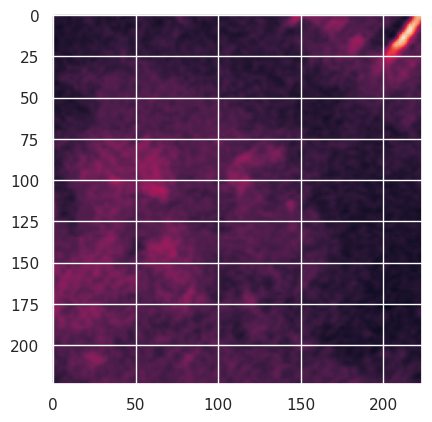

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
192 total pats: ['129_', '130_', '197_', '202_', '66_', '159_', '155_', '87_', '60_', '148_', '99_', '74_', '190_', '18_', '81_', '22_', '50_', '4_', '39_', '40_', '206_', '191_', '182_', '12_', '86_', '101_', '96_', '139_', '212_', '147_', '2_', '61_', '62_', '122_', '94_', '95_', '45_', '5_', '204_', '43_', '213_', '214_', '63_', '184_', '93_', '174_', '73_', '160_', '161_', '143_', '91_', '183_', '176_', '70_', '75_', '199_', '102_', '175_', '178_', '34_', '57_', '138_', '109_', '105_', '71_', '163_', '76_', '125_', '126_', '11_', '9_', '110_', '116_', '173_', '31_', '35_', '46_', '88_', '89_', '150_', '151_', '152_', '128_', '140_', '114_', '28_', '172_', '104_', '111_', '134_', '65_', '64_', '154_', '153_', '186_', '185_', '1_', '25_', '198_', '55_', '201_', '170_', '144_', '106_', '100_', '80_', '27_', '181_', '194_', '33_', '58_', '149_', '112_', '83_', '207_', '208_', '42_', '14_', '1

In [213]:
labelpath = DATA_ROOT + "label_df.csv"
#train_set = DatasetThyroid3StackedNew(file["image"], file["mask"], file["annot_id"], "/.", "test", config['cvphase'], config['frametype'], transform=transformAug)
homedir = "/media/iadam/STORAGE/code_repos/FALL_23/BE223A/cineroid/[PREV]thyroid_deep_learning/"

#target fold, validation only gets that fold
target_image = DatasetThyroid3StackedNew(file["image"], file["mask"], labelpath, homedir, phase_type, target_fold, "adjacent", transform=transformNorm)
target_image_loader = DataLoader(dataset=target_image, num_workers=0, batch_size=16, shuffle=True)

In [214]:
seed_value = 1
torch.manual_seed(seed_value)

ttotal = 0
tcorrect = 0

losses = []
f_losses = []
losses_val = []
f_losses_val = []

total_all = 0
correct_all = 0

all_labels = []
all_probs_ones = []
all_patients = []
all_preds = []

#learning rate
lrs = []

correct = 0
total = 0
valcount = 0.0
traincount = 0.0
traincorrect = 0.0
traintotal = 0.0
trainlen = 0

running_loss = 0.0
running_focal_loss = 0.0
running_loss_val = 0.0
running_focal_loss_val = 0.0

floss_alpha = 0.9
floss_gamma = 2.4

tlabelsnp = np.zeros(16)
epoch_aurocs = []


#default for early stopping
min_val_loss = 10
prev_val_loss = 10
epochs_no_improve = 0
early_stop = False
min_epoch = 0

lr = 0.001

## Choose Backbone

In [215]:
!ls ./ViTS16_backbone_weights

backbone_implementation_FOLD0


In [216]:
pretrained_path = "ViTS16_backbone_weights/backbone_implementation_FOLD0"

---------------------------------------------------------------------------

**run cells that are either mobilenet cells or vit cells**

mobilenet

In [ ]:
tmodel = models.mobilenet_v2(pretrained=False)
tmodel.classifier._modules['1'] = nn.Linear(1280, 256)
tmodel.classifier._modules['2'] = nn.Linear(256, 2)

tmodel.load_state_dict(torch.load(pretrained_path))

for param in tmodel.parameters():
    param.requires_grad = False

#remove last layer:
tmodel.classifier = tmodel.classifier[:-1]
tmodel

vit

In [217]:
tmodel = torchvision.models.get_model("vit_b_16", weights="DEFAULT")
weights = torchvision.models.get_model_weights("vit_b_16")

#modify actual classifier
#MAKE SURE THAT THE INPUT SIZE IS THE SAME AS THE FC IN PRETRAINED
class classifier_output(nn.Module):
    def __init__(self):
        super(classifier_output, self).__init__()
        self.classifier1 = nn.Linear(768, 256)
        self.classifier2 = nn.Linear(256, 2)
        
    def forward(self, x):
        x = self.classifier1(x).relu()
        x = self.classifier2(x)
        return x

classifier = classifier_output()
tmodel.heads = classifier

preprocessing = weights.IMAGENET1K_V1.transforms()

tmodel.load_state_dict(torch.load(pretrained_path))
for param in tmodel.parameters():
    param.requires_grad = False
    
#remove last layer:
tmodel.heads = nn.Sequential(*list(tmodel.heads.children())[:-1])
tmodel

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

------------------------------------

In [218]:
print('trainable parameters', sum(p.numel() for p in tmodel.parameters() if p.requires_grad == True))
print('non-trainable parameters', sum(p.numel() for p in tmodel.parameters() if p.requires_grad == False))

trainable parameters 0
non-trainable parameters 85995520


In [219]:
#moves to gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tmodel = tmodel.to(device)

In [220]:
import warnings
warnings.filterwarnings("ignore")

In [221]:
!ls 

 1.data_preprocess.py			       install_requirements
'2. MobileNet-v2 Backbone Training.ipynb'      LICENSE
'2. ShuffleNetv2 Backbone Training.ipynb'      mobilenet_backbone_weights
'2. ViT-S-16 Backbone Training.ipynb'	       README.md
'3. Generate Embeddings From Backbone.ipynb'   requirements.txt
 backbone_embeddings			       shufflenet_backbone_weights
 data					       torch_requirements.txt
 DEPRECATED_requirements.txt		       ViTS16_backbone_weights
 EDA


### Generating Embeddings

In [222]:
if "mobilenet_backbone_weights" in pretrained_path:
    if phase_type == "all":
        filename = "backbone_embeddings/mobilenet_embeddings_ALL_IMAGES.csv"
    else:
        filename = "backbone_embeddings/mobilenet_embeddings_FOLD%s.csv" % target_fold
elif "ViTS16_backbone_weights" in pretrained_path:
    filename = "backbone_embeddings/ViT_embeddings_FOLD%s.csv" % target_fold


In [223]:
all_probs = np.zeros((0,256)) #to save for transformer inputs
val_probs = np.zeros((0,256))
test_probs = np.zeros((0,256))

all_labels = []
all_probs_ones = []
all_patients = []
all_preds = []
all_framenums = []

test_preds = []

total = 0
correct = 0

In [224]:
tmodel.eval() #test mode but on training dataset before transformer
with torch.no_grad():
    print("train set len: %s" % len(target_image_loader))
    for i, data in tqdm(enumerate(target_image_loader)):
        inputs = data['input'].to(device)
        labels = data['label'].to(device)
        annot_ids = data['annot_id']
        frame_nums = data['frame_num']
    
        # Forward pass only to get logits/output
        outputs = tmodel(inputs)
        labels = labels.squeeze()
    
        #add these raw outputs to list for transformer
        all_probs = np.concatenate((all_probs, outputs.detach().cpu().numpy()))
        if (i % 100 == 0):
            print("in train: probabilities shape for transformer (should be [xx, 2])", np.shape(all_probs))            

        sf = nn.Softmax(dim=1) #makes items in a row add to 1; dim = 0 makes items in a column add to 1
        outputs = sf(outputs)
    
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs, 1)
        
        #add labels + predictions to full set for auroc later
        if torch.cuda.is_available():
            outs_ones = outputs.detach().cpu().numpy()[:, 1]
            labelsnp = labels.cpu().numpy()
        else:
            outs_ones = outputs.detach().numpy()[:, 1]
            labelsnp = labels.numpy()
    
        all_labels = np.append(all_labels, labelsnp)
        all_probs_ones = np.append(all_probs_ones, outs_ones)
    
        annot_ids = np.asarray(annot_ids)
        frame_nums = np.asarray(frame_nums)
    
        all_patients = np.append(all_patients, annot_ids)
        all_framenums = np.append(all_framenums, frame_nums)

#write to csv file: train and val
print(len(all_patients))

print("\n\ntrain writing features to csv")
f=open(filename,'w', newline ='\n')
count = 0
for i,l,j,k in zip(all_patients, all_labels, all_probs, all_framenums):
    if (count % 200 == 0):
        print(np.shape(i), np.shape(l), np.shape(j))
    f.write(str(k)) #framenumViTS16_backbone_weights
    f.write("," +str(i)) #annot_id
    f.write("," + str(int(l))) #label
    abc=0
    for prprpr in j:
        f.write("," + str(prprpr))
        abc+=1
    if(count%500 == 0):
        print(abc)
    f.write("\n")
    count += 1
f.close()

train set len: 72


0it [00:00, ?it/s]

in train: probabilities shape for transformer (should be [xx, 2]) (16, 256)
1142


train writing features to csv
() () (256,)
256
() () (256,)
() () (256,)
256
() () (256,)
() () (256,)
() () (256,)
256


In [225]:
filename

'backbone_embeddings/ViT_embeddings_FOLD3.csv'